In [1]:
#===============================================================================================
# IUGG 2019 Plots
#
#  Tracer flux as a function of parameters
#
#  * scaling
#===============================================================================================

In [2]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.lines import Line2D
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [3]:
sns.set_style('white')
sns.set_context('talk')

def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

def Z(U,f,L,W,N,s):
    '''depth of upwelling as in Howatt and Allen 2013'''
    return(1.8*(F(Ro(U,f,W))*Ro(U,f,L))**(0.5) *(1-0.42*SE(s,N,f,F(Ro(U,f,W)),Ro(U,f,L)))+0.05)



In [5]:
g = 9.81 # accel. gravity
s = np.array([0.00230,0.00230,0.00454,0.00454]) # shelf slope 
N = np.array([0.0055,0.0088,0.0055,0.0038]) # Initial at 152.5 m
f = np.array([1.0E-4,1.05E-4,1.0E-4,1.08E-4])
U = np.array([0.3,0.329,0.3,0.288])
Wiso = np.array([8900,8900,8300,8300])
L = np.array([21800,21800,6400,6400])
K = np.array([1E-5,1E-5,1E-5,1E-5])
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

head_zind = [19,19,34,34]
Z_zind = [30,20,14,21]

RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
state_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
stateA = xr.open_dataset(state_fileA)
state_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc'
stateB = xr.open_dataset(state_fileB)

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]

with Dataset(grid_fileA, 'r') as nbl:
        drC_A = nbl.variables['drC'][:] 

with Dataset(grid_fileB, 'r') as nbl:
        drC_B = nbl.variables['drC'][:] 
        

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
sb_conc_A = np.empty(len(tracers))
sb_conc_B = np.empty(len(tracers))
sb_gradtop_A = np.empty(len(tracers))
sb_gradtop_B = np.empty(len(tracers))
sb_gradZ_Ast = np.empty(len(tracers))
sb_gradZ_Argo = np.empty(len(tracers))
sb_gradZ_Bar = np.empty(len(tracers))
sb_gradZ_Path = np.empty(len(tracers))


for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,sb_array,gradtop_array,\
    sb_ind,drc,state in zip([ptr_fileA, ptr_fileB],
                            [sb_conc_A, sb_conc_B],
                            [sb_gradtop_A, sb_gradtop_B],
                            [sb_Ast, sb_Bar],
                            [drC_A, drC_B],
                            [stateA, stateB]):
        with Dataset(pfile, 'r') as nbl:
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = 1E-3*nbl.variables[trac][0,:,10,180] # nM to muM
              
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = density.data*profile.data/1000 # mumol/kg muM to 
            else:
                tr_profile = nbl.variables[trac][0,:,10,180] # muM
            
            tr_grad = (tr_profile[2:]-tr_profile[:-2])/(drc[3:]+drc[1:-2])
                
            sb_array[ii] = tr_profile[sb_ind]
            gradtop_array[ii] = np.nanmean(tr_grad[sb_ind-8:sb_ind])     
            
            
for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,head_ind,Z_ind,grad_array,drc,state in zip([ptr_fileA,ptr_fileA,ptr_fileB,ptr_fileB],
                                                        head_zind, Z_zind,
                                                        [sb_gradZ_Ast,sb_gradZ_Argo,
                                                        sb_gradZ_Bar,sb_gradZ_Path],
                                                        [drC_A, drC_A,drC_B, drC_B],
                                                        [stateA, stateA,stateB, stateB]):
        with Dataset(pfile, 'r') as nbl:
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = 1E-3*nbl.variables[trac][0,:,10,180] # nM to muM
              
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = density.data*profile.data/1000 # mumol/kg muM to 
            else:
                tr_profile = nbl.variables[trac][0,:,10,180] # muM
            
            tr_grad = (tr_profile[2:]-tr_profile[:-2])/(drc[3:]+drc[1:-2])
            grad_array[ii] = np.nanmean(tr_grad[head_ind:head_ind+Z_ind]) 

In [6]:
labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
markers=['o','^','s','d']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']
runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']

sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_grad = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_gradtop = [sb_gradtop_A,sb_gradtop_A, sb_gradtop_B,sb_gradtop_B]

In [7]:
#---- Fit PhiTr --------------------------------------------------------------------
Phi_array = np.zeros(40)
x_array = np.zeros(40)

kk = 0

for tr, ii in zip(tracer_keys, range(len(labels_tra))):
    for run_phi,lab_exp,exp,grad,conc,ff,nn,uu,ll,ww,ss in zip(runs_phi,
                                                               labels_exp,
                                                               exps,
                                                               sb_grad,
                                                               sb_conc,
                                                               f,N,U,L,Wiso,s,
                                                               ):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        Cs=conc[ii]
        
        file = ('/data/kramosmu/results/TracerExperiments/%s/phi_phiTr_transAlg_%s.csv' %(exp,run_phi))
        df = pd.read_csv(file)
        if (tr == 'phiTr07' or tr == 'phiTr08'):
            TrMass = df[tr][:]# nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = 1000*df['Phi'][:]# m^3 to l
        else:
            TrMass = 1E3*df[tr][:] # nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = 1000*df['Phi'][:]# m^3 to l
        
        PhiTr = np.mean(np.array(TrMass[8:18]))
        Phi = np.mean(np.array(HCW[8:18]))
        Phi_array[kk]=PhiTr/(Phi*Cs)
        x_array[kk] = ZZ*grad[ii]/Cs
        
        kk = kk+1 

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_array,Phi_array)

print('slope = %1.2f, intercept = %1.3f, r-value = %1.3f, std_err = %1.3f' \
      %(slope, intercept, r_value, std_err))


slope = 0.57, intercept = 0.982, r-value = 0.966, std_err = 0.025


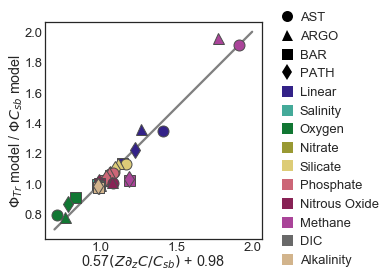

In [19]:
# ----------- Plot fitted data ------------------------------------
fig,ax0 = plt.subplots(1,1,figsize=(4,4))
ax0.plot(np.linspace(0.7,2,20),np.linspace(0.7,2,20),'-',color='0.5')
kk = 0

for tr_lab, col in zip(labels_tra, colours):
    for mark in markers:

        ax0.plot(slope*(x_array[kk])+intercept,Phi_array[kk], marker=mark,markerfacecolor=col, 
                 markeredgecolor='0.3', markeredgewidth=1, markersize=11)
       
        kk = kk+1

ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)

legend_runs     = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=11),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=11),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=11),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=11),
                   ]

for ii in range(len(colours)):
    legend_runs.append(Line2D([0], [0], marker='s',color='w', label=labels_tra[ii],
                        markerfacecolor=colours[ii], mec=colours[ii],markersize=11),)

ax0.legend(handles=legend_runs, bbox_to_anchor=(1,1.1), handletextpad=0)
ax0.set_xlabel(r'%1.2f$ (Z \partial_zC / C_{sb})$ + %1.2f' %(slope,intercept), labelpad=0)
ax0.set_ylabel('$\Phi_{Tr}$ model / $\Phi C_{sb}$ model', labelpad=0)
ax0.set_aspect(1)

plt.savefig('04_PhiTr_scaling.pdf',format='pdf', bbox_inches='tight')

In [23]:
labels_exp = ['AST', 'ARGO','BAR', 'PATH']
factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
exp_files = ['../../saved_calcs/pool_AST.nc',
             '../../saved_calcs/pool_ARGO.nc',
             '../../saved_calcs/pool_BAR.nc',
             '../../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01','UPW_10TR_BF4_BAR_03']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']
runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']
can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]

area_array = np.zeros(40)
Pi_array = np.zeros(40)
kk = 0

for ii, col in zip(range(len(labels_tra)),colours):
    for file,run,lab_exp, can_area,exp, \
    grad,gradtop,conc,ff,nn,uu,ll,ww,ss,KK in zip(exp_files, 
                                                  runs,
                                                  labels_exp,
                                                  can_Area,exps,
                                                  sb_grad,
                                                  sb_gradtop,
                                                  sb_conc,
                                                  f,N,U,L,Wiso,s,K,
                                                  ):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        Cs=conc[ii]
         
        # Plot area vs tau
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    Pi_array[kk]=uu*ZZ*grad[ii]/(KK*gradtop[ii])
                    area_array[kk]=np.nanmax(area[ii,:])/can_area
                else:
                    Pi_array[kk]=uu*ZZ*grad[ii]/(KK*gradtop[ii])
                    area_array[kk]=np.nanmax(area[ii,:])/can_area
            else:
                if lab_exp=='BAR':
                    Pi_array[kk]=uu*ZZ*grad[ii]/(KK*gradtop[ii])
                    area_array[kk]=np.nanmax(area[ii,:])/can_area
                else:
                    Pi_array[kk]=uu*ZZ*grad[ii]/(KK*gradtop[ii])
                    area_array[kk]=np.nanmax(area[ii,:])/can_area
        
            kk=kk+1     
         

slope0, intercept0, r_value0, p_value0, std_err0 = scipy.stats.linregress(Pi_array,area_array)

print('slope = %1.2e, intercept = %1.3f, r-value = %1.3f, std_err = %1.3e' \
      %(slope0, intercept0, r_value0, std_err0))


slope = 7.56e-06, intercept = -3.687, r-value = 0.900, std_err = 5.941e-07


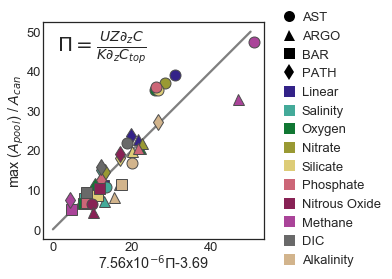

In [44]:
# ----------- Plot fitted data ------------------------------------
fig,ax0 = plt.subplots(1,1,figsize=(4,4))
ax0.plot(np.linspace(0,50,20),np.linspace(0,50,20),'-',color='0.5')
kk = 0

for tr_lab, col in zip(labels_tra, colours):
    for mark in markers:

        ax0.plot(slope0*(Pi_array[kk])+intercept0,area_array[kk], marker=mark,markerfacecolor=col, 
                 markeredgecolor='0.3', markeredgewidth=1, markersize=11)
       
        kk = kk+1

ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)

legend_runs     = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=11),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=11),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=11),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=11),
                   ]

for ii in range(len(colours)):
    legend_runs.append(Line2D([0], [0], marker='s',color='w', label=labels_tra[ii],
                        markerfacecolor=colours[ii], mec=colours[ii],markersize=11),)

ax0.legend(handles=legend_runs, bbox_to_anchor=(1,1.1), handletextpad=0)
ax0.set_xlabel(r'7.56x10$^{-6}$$\Pi$%1.2f' %(intercept0), labelpad=0)
ax0.set_ylabel('max ($A_{pool}$) / $A_{can}$', labelpad=0)
ax0.set_aspect(1)

ax0.text(1,45,r'$\Pi=\frac{UZ\partial_zC}{K\partial_zC_{top}}$', fontsize=20)
plt.savefig('05_PoolArea_scaling.pdf',format='pdf', bbox_inches='tight')